# Построение модели ARIMA для RTSI

В этой программе рассмотрим построение модели ARIMA для RTSI. Известны данные по индексу RTSI за 1998-2017 года, необходимо построить прогноз на следующие 3 года.

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

Populating the interactive namespace from numpy and matplotlib


Введем датасет(набор данных) состоящий из даты и значений акций, входящие в индекс

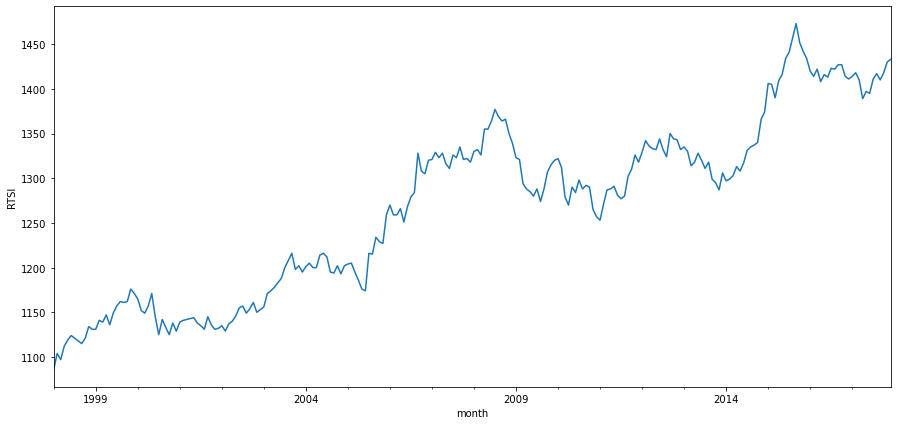

In [2]:
df = pd.read_csv('C:/Users/user/Desktop/Practice-2020-master/VASYA4.csv',',', index_col=['month'], parse_dates=['month'], dayfirst=True)
plt.figure(figsize(15,7))
df.id.plot()
plt.ylabel('RTSI')
pylab.show()

Здесь определим Критерий Дики-Фуллера, проверку стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.722331


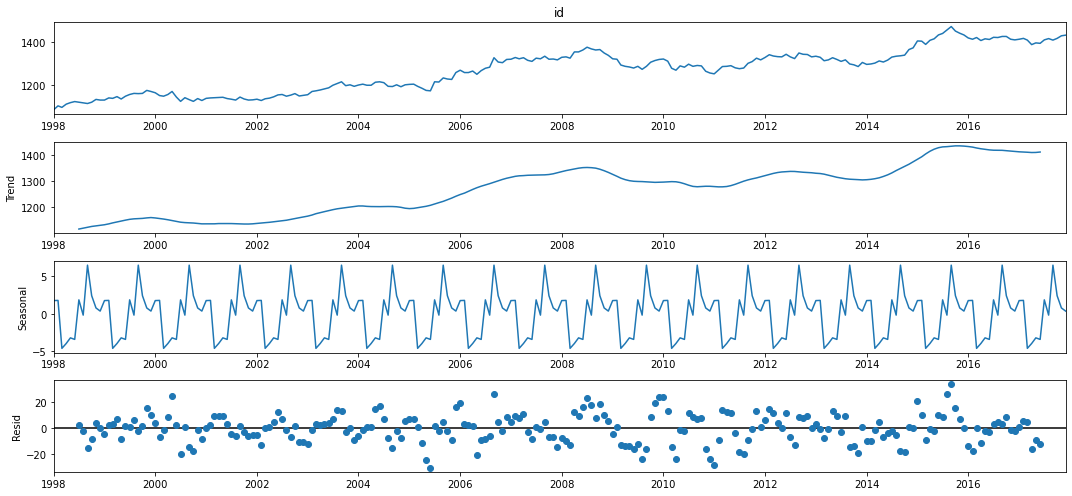

In [3]:
sm.tsa.seasonal_decompose(df.id,period=12).plot()
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.id)[1])

# Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии. Получим оптимальный параметр преобразования Бокса-Кокса:

Оптимальный параметр преобразования Бокса-Кокса: 0.735590
Критерий Дики-Фуллера: p=0.705577


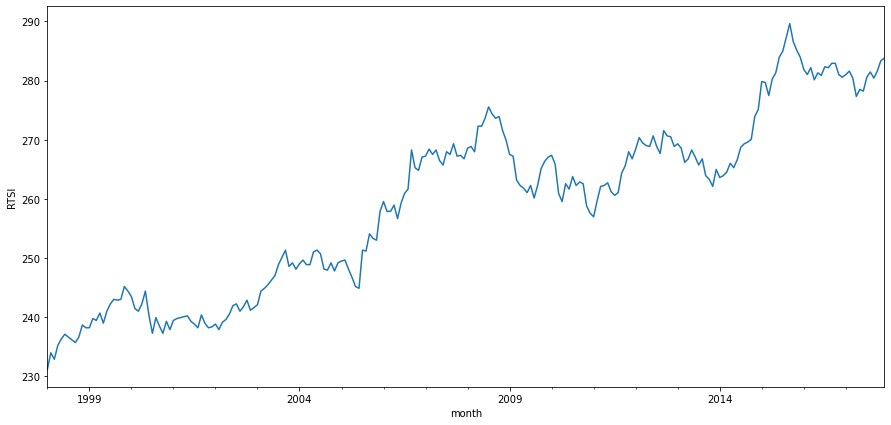

In [4]:
df['sales_box'], lmbda = stats.boxcox(pd.to_numeric(df.id))
plt.figure(figsize(15,7))
df.sales_box.plot()
plt.ylabel(u'RTSI')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.sales_box)[1])

# Стационарность

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.027741


<Figure size 1080x720 with 0 Axes>

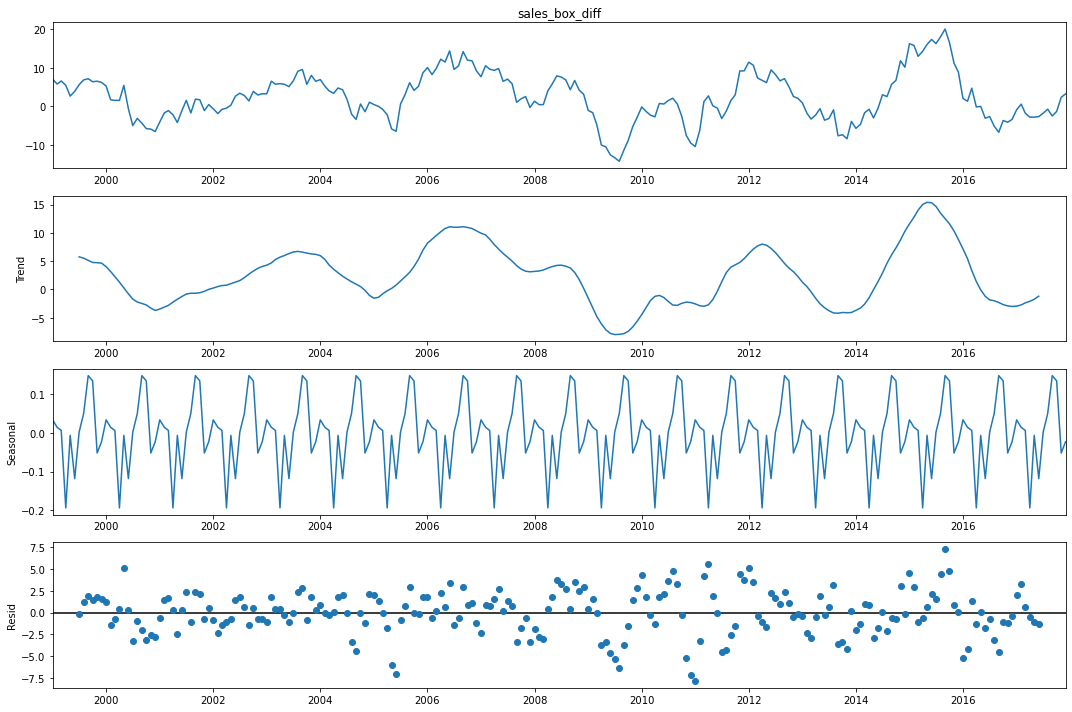

In [5]:
df['sales_box_diff'] = df.sales_box - df.sales_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.sales_box_diff[12:],period=12).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.sales_box_diff[12:])[1])

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

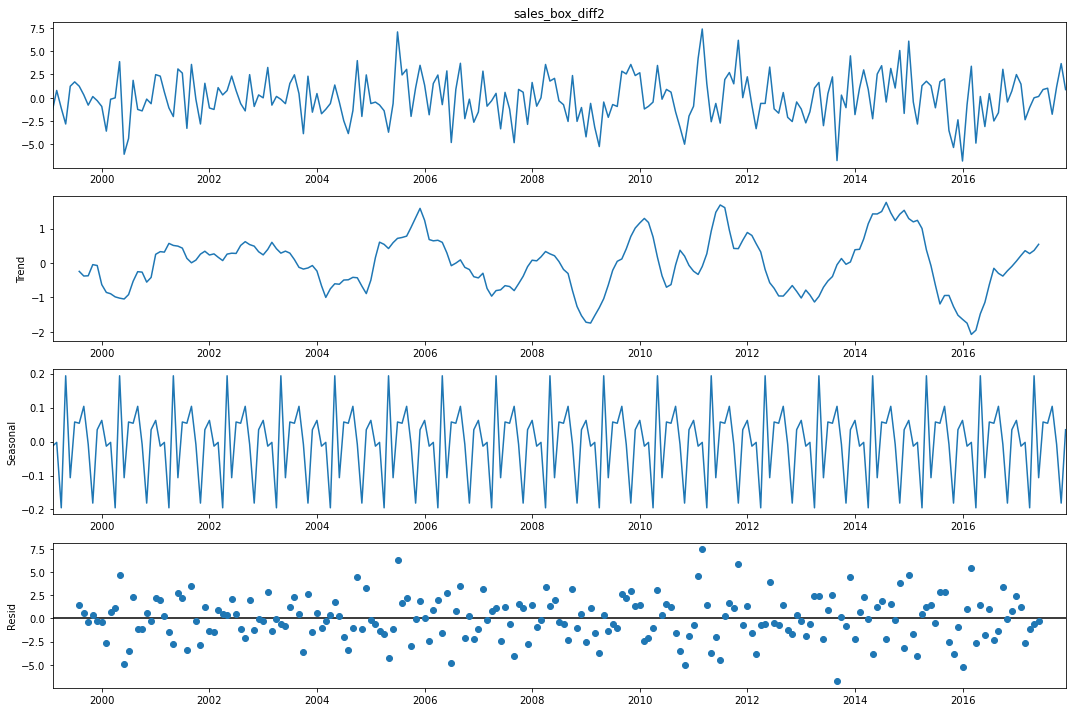

In [6]:
df['sales_box_diff2'] = df.sales_box_diff - df.sales_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.sales_box_diff2[13:],period=12).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.sales_box_diff2[13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет.

# Подбор модели

Посмотрим на ACF и PACF полученного ряда:

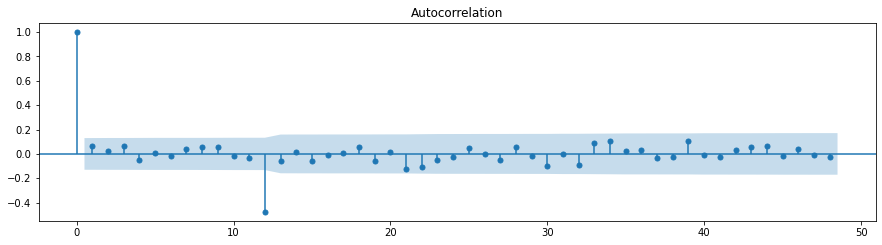

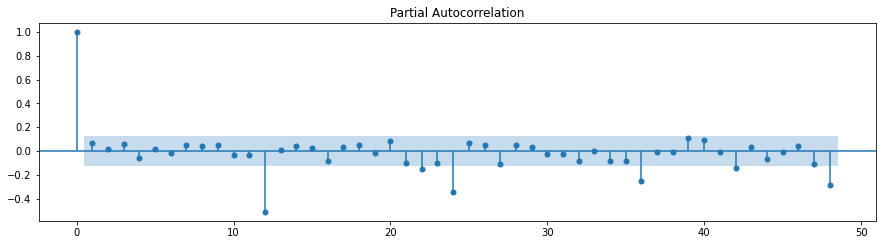

In [7]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.sales_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.sales_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=1, q=2, P=1, p=4

In [8]:
ps = range(0, 5)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [9]:
from itertools import product
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

Выводим параметры, на которых модель не обучается и переходим к следующему набору:

In [10]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df.sales_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 1min


Если в предыдущей ячейке возникает ошибка, убедитесь, что обновили statsmodels до версии не меньше 0.8.0rc1

In [11]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
1   (0, 0, 0, 1)  926.688177
21  (1, 2, 0, 1)  928.121040
13  (1, 0, 0, 1)  928.676027
5   (0, 1, 0, 1)  928.676121
3   (0, 0, 1, 1)  928.683255


C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Получим лучшую модель:

In [12]:
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                            sales_box   No. Observations:                  240
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -461.344
Date:                              Tue, 20 Apr 2021   AIC                            926.688
Time:                                      15:06:24   BIC                            933.538
Sample:                                  01-01-1998   HQIC                           929.452
                                       - 12-01-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.9995     11.928     -0.084      0.933     -24.379      22.380
sigma2         2.91

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Её остатки:

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Критерий Стьюдента: p=0.592138
Критерий Дики-Фуллера: p=0.000000


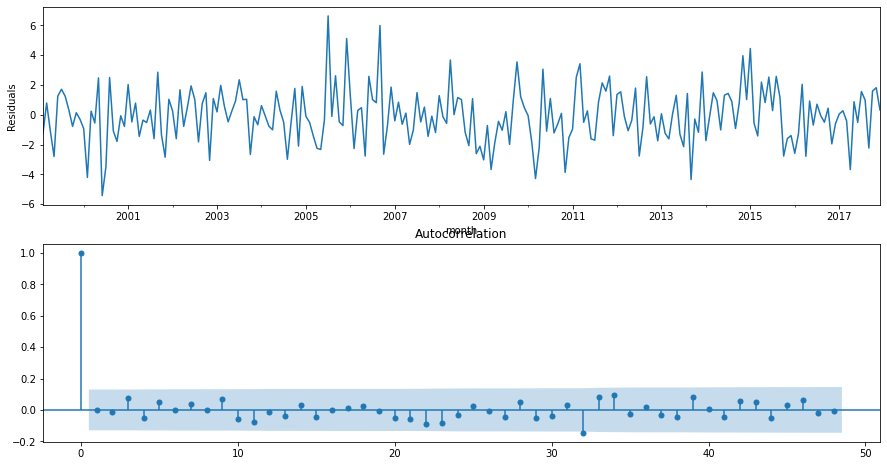

In [13]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


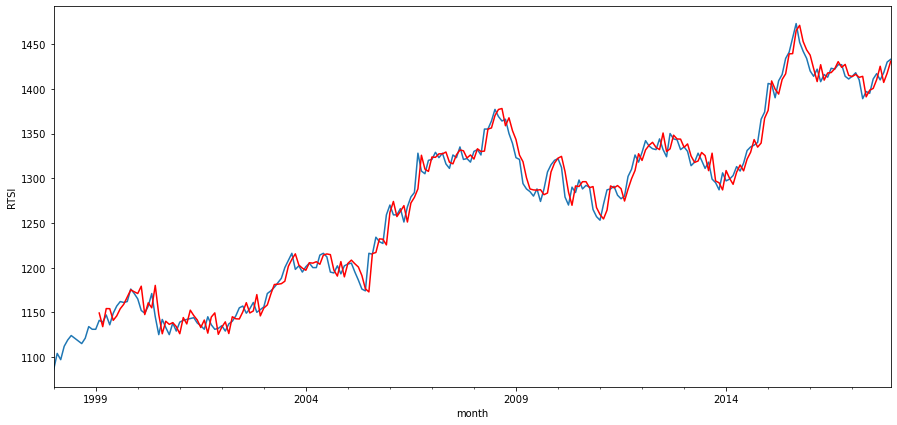

In [14]:
df['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
df.id.plot()
df.model[13:].plot(color='r')
plt.ylabel('RTSI')
pylab.show()

# Прогноз

Построим прогноз

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


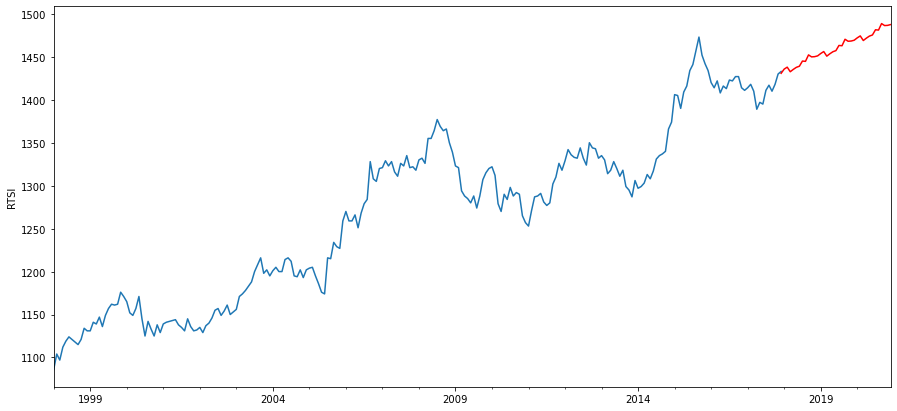

In [15]:
df2= df[['id']]
date_list = [datetime.datetime.strptime("2018-01-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = invboxcox(best_model.predict(start=239, end=500), lmbda)

plt.figure(figsize(15,7))
df2.id.plot()
df2.forecast.plot(color='r')
plt.ylabel('RTSI')
pylab.show()

Добавим данные за 2018-2020 года, чтобы сравнить с прогнозом

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


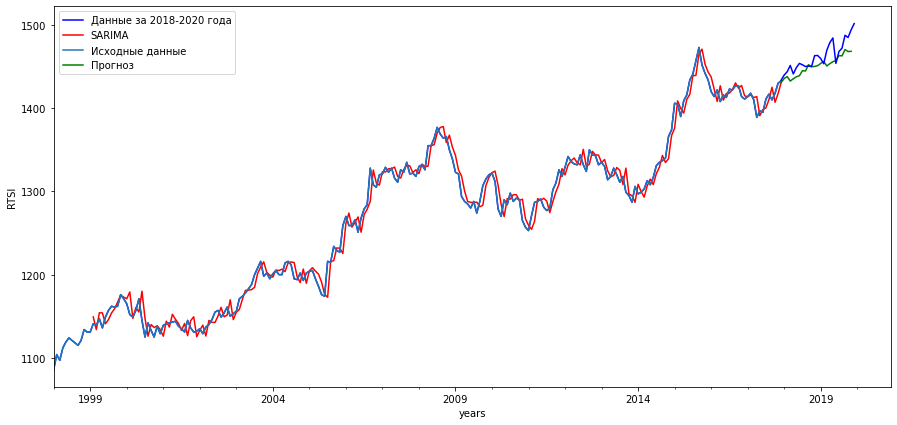

In [16]:
df['model'] = invboxcox(best_model.fittedvalues, lmbda) #not predict

df2= df[['id']]
date_list = [datetime.datetime.strptime("2018-01-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = invboxcox(best_model.predict(start=239, end=262), lmbda)

df3 = pd.read_csv('C:/Users/user/Downloads/Practice-2020-master/Practice-2020-master/VASYA1.csv',',', index_col=['month'], parse_dates=['month'], dayfirst=True)
df.id.plot(color='blue')
df.model[13:].plot(color='red')
df2.id.plot()
df2.forecast.plot(color='green')
df3.id.plot(color='blue')
plt.legend(['Данные за 2018-2020 года',  'SARIMA', 'Исходные данные', 'Прогноз' ],)
plt.ylabel('RTSI')
plt.xlabel('years')
pylab.show()


#plt.plot(x, y1, 'o-r')
#plt.plot(x, y2, 'o-.g')
#plt.legend(['L1', 'L2'])

In [17]:
from sklearn import tree
import seaborn as sns
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
%matplotlib inline 

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 f

In [18]:
#y = df.id
#X = df
#tscv = TimeSeriesSplit()
#print(tscv)

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
import sys
import warnings

warnings.filterwarnings("ignore")
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from scipy.optimize import minimize
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm

%matplotlib inline


<Figure size 1080x504 with 0 Axes>

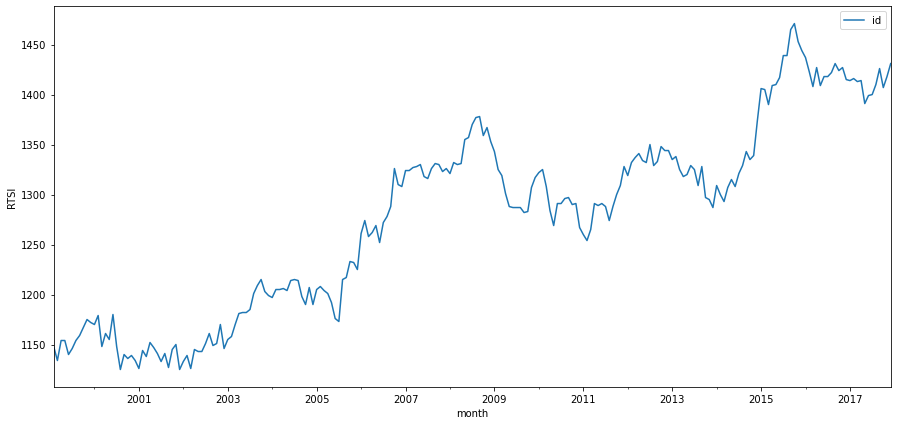

In [20]:

df6 = pd.read_csv('C:/Users/user/Desktop/event_data_train/VASYA6.csv',',', index_col=['month'], parse_dates=['month'], dayfirst=True)
#C:\Users\user\Downloads
plt.figure(figsize(15,7))
df6.plot()
plt.ylabel('RTSI')
pylab.show()

In [21]:
#df5 = df.model[13:]
#df5.plot(color='red')


In [22]:
from sklearn.model_selection import TimeSeriesSplit
#Specify fold and perform splitting
# Указать сгиб и выполнить разделение
tscv = TimeSeriesSplit(n_splits=3)
tscv.split(df)
#Find out no of observations in train and test sets
# Узнать количество наблюдений в тренировочных и тестовых наборах
i = 0
i=i+1
for train, test in tscv.split(df):
    
    print ("No of observations under train%s=%s" % (i, len(train)))
    print ("No of observations under test%s=%s" % (i, len(test)))

No of observations under train1=60
No of observations under test1=60
No of observations under train1=120
No of observations under test1=60
No of observations under train1=180
No of observations under test1=60


In [23]:
train1, test1 = df.iloc[:60, 0], df.iloc[60:120, 0]
train2, test2 = df.iloc[:120, 0], df.iloc[120:180, 0]
train3, test3 = df.iloc[:180, 0], df.iloc[180:240, 0]

In [24]:
print(param)
print(model)

(4, 2, 1, 1)


In [45]:
#Fit a model
#from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
#mse = mean_squared_error(Y_train,y_train_price)
#r_squared = r2_score(Y_train,y_train_price)
#print('Mean_Squared_Error :' ,mse)
#print('r_square_value :',r_squared)

#for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
#    try:
#        model=sm.tsa.statespace.SARIMAX(df.sales_box, order=(param[0], d, param[1]), 
#seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
#    except ValueError:
#        print('wrong parameters:', param)
#        continue
#    aic = model.aic
#    #сохраняем лучшую модель, aic, параметры
#    if aic < best_aic:
#        best_model = model
#        best_aic = aic
#        best_param = param
#    results.append([param, model.aic])

#First fold RMSE
#model1 = ExponentialSmoothing(train1, seasonal='mul', seasonal_periods=12).fit()
#pred1 = model1.predict(start=test1.index[0], end=test1.index[-1])
#r_squared1 = r2_score(test1, pred1)
#RMSE1=round(sqrt(mean_squared_error(test1, pred1)),2)

#model = SARIMAX(data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 1))    

#model1=sm.tsa.statespace.SARIMAX(df.sales_box, train1, order=(param[0], d, param[1]), 
                                        #seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)

#First fold RMSE
param1=sm.tsa.statespace.SARIMAX(train1, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1) 
pred1 = model1.predict(start=test1.index[0], end=test1.index[-1])
#_squared1 = r2_score(test1, pred1)
#RMSE1=round(sqrt(mean_squared_error(test1, pred1)),2)



#rint ("RMSE1:", RMSE1)
#rint ("RMSE2:", RMSE2)
#rint ("RMSE3:", RMSE3)
print('r_square_value1 :',r_squared1)
#rint('r_square_value2 :',r_squared2)
#rint('r_square_value3 :',r_squared3)

#Overall_r_squared=round((r_squared1+r_squared2+r_squared3)/3,2)
#print ("Overall r_squared:", Overall_r_squared)    


r_square_value1 : -0.0662463046089532


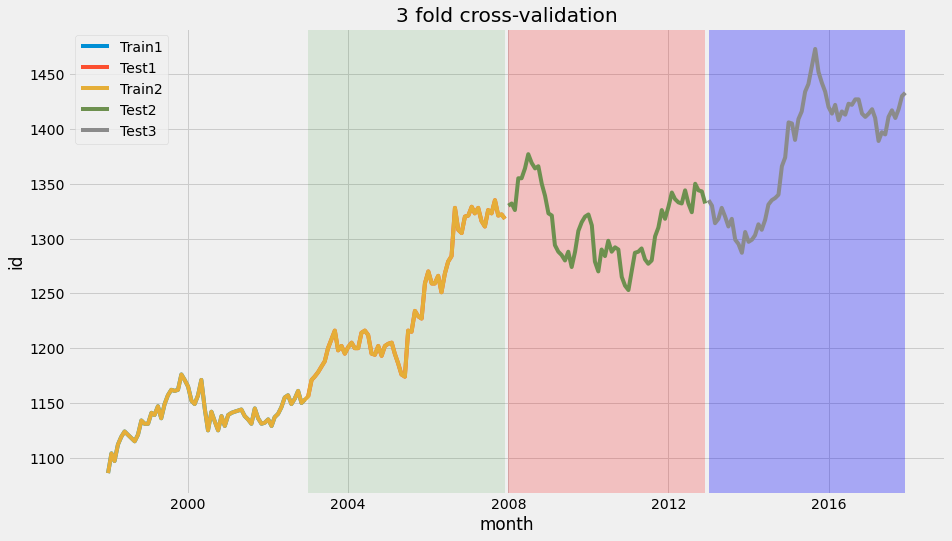

In [40]:
import matplotlib.pyplot as plt
#from statsmodels.tsa.holtwinters import ExponentialSmoothing
%matplotlib inline
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 14,8

#Labels and titles
plt.xlabel("month")
plt.ylabel("id")
plt.title("3 fold cross-validation")

#First fold- CV
plt.plot(train1.index, train1, label='Train1')
plt.plot(test1.index, test1, label='Test1')
#plt.plot(pred1.index, pred1, label='prediction1')
plt.legend(loc='best')
#Highlighting the region
plt.axvspan(test1.index[0], test1.index[-1],  facecolor='g', alpha=0.1)

#Second fold
plt.plot(train2.index, train2, label='Train2')
plt.plot(test2.index, test2, label='Test2')
#plt.plot(pred2.index, pred2, label='prediction2')
plt.legend(loc='best')
#Highlighting the region
plt.axvspan(test2.index[0], test2.index[-1],  facecolor='r', alpha=0.2)

#Third fold
plt.plot(test3.index, test3, label='Test3')
#plt.plot(pred3.index, pred3, label='prediction3')
plt.legend(loc='best')
#Highlighting the region
plt.axvspan(test3.index[0], test3.index[-1],  facecolor='b', alpha=0.3)

In [33]:
#df2.id.plot()
#df2.forecast.plot(color='green')

In [34]:
#df7 = pd.read_csv('C:/Users/user/Desktop/VASYA7.csv',',', index_col=['month'], parse_dates=['month'], dayfirst=True)
#plt.figure(figsize(15,7))
#df7.plot()
#plt.ylabel('RTSI')
#pylab.show()

In [38]:
#Fit a model
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

#model = ExponentialSmoothing(train, seasonal='mul', seasonal_periods=3).fit()
#pred = model.predict(start=test.index[0], end=test.index[-1])
#r_squared = r2_score(test, pred)
#print('r_square_value :',r_squared)


In [32]:
#df11 = pd.read_csv('C:/Users/user/Desktop/VASYA11.csv',',', index_col=['month'], parse_dates=['month'], dayfirst=True)
#plt.figure(figsize(15,7))
#df11.id.plot()
#plt.ylabel('RTSI')
#pylab.show()

## Коэффициент детерминации для тестовой выборки (test)

In [30]:
#from sklearn.metrics import r2_score
#y_true = df11
#y_pred = df7
#r2_score(y_true, y_pred)

In [31]:
#y_true.plot()
#y_pred.plot()

## Коэффициент детерминации для тренировочной выборки (train)

In [25]:
#true 
#df41 = pd.read_csv('C:/Users/user/Desktop/VASYA41.csv',',', index_col=['month'], parse_dates=['month'], dayfirst=True)
#plt.figure(figsize(15,7))
#df41.plot()
#plt.ylabel('RTSI')
#pylab.show()

In [26]:
#pred
#df61 = pd.read_csv('C:/Users/user/Desktop/VASYA61.csv',',', index_col=['month'], parse_dates=['month'], dayfirst=True)
#plt.figure(figsize(15,7))
#df61.plot()
#plt.ylabel('RTSI')
#pylab.show()

In [27]:
#df41.plot()
#df61.plot()

In [28]:
#print(df41.shape)
#print(df61.shape)

In [29]:
#from sklearn.metrics import r2_score
#y_true = df41
#y_pred = df61
#r2_score(y_true, y_pred)

In [60]:
model

In [46]:
df

,id,sales_box,sales_box_diff,sales_box_diff2,model
month,,,,,
1998-01-01,1086,231.177204,NaN,NaN,1.000000
1998-02-01,1104,234.006146,NaN,NaN,1086.000000
1998-03-01,1097,232.907462,NaN,NaN,1104.000000
1998-04-01,1112,235.259533,NaN,NaN,1097.000000
1998-05-01,1119,236.354291,NaN,NaN,1112.000000
...,...,...,...,...,...
2017-08-01,1417,281.441954,-0.733695,1.027995,1410.339133
2017-09-01,1410,280.413630,-2.495032,-1.761337,1425.237712
2017-10-01,1418,281.588748,-1.319914,1.175118,1407.172966
